In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score

# Análise dos dados

In [2]:
dataset = pd.read_csv('diabetes_prediction_dataset.csv')

In [3]:
df = dataset.copy()
df.sample(4)

,genero,idade,hipertensao,doenca_cardiaca,historico_tabagismo,gordura_corporal,acucar_sangue_ha_2_meses,nivel_glicose_sangue,diabetes
62087,Male,65.0,0,0,No Info,32.98,4.5,126,0
39024,Female,29.0,0,0,former,27.32,4.8,160,0
62264,Female,54.0,0,0,never,24.51,6.0,145,0
54973,Male,11.0,0,0,No Info,16.95,6.1,85,0


In [4]:
df.shape

(100000, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   genero                    100000 non-null  object 
 1   idade                     100000 non-null  float64
 2   hipertensao               100000 non-null  int64  
 3   doenca_cardiaca           100000 non-null  int64  
 4   historico_tabagismo       100000 non-null  object 
 5   gordura_corporal          100000 non-null  float64
 6   acucar_sangue_ha_2_meses  100000 non-null  float64
 7   nivel_glicose_sangue      100000 non-null  int64  
 8   diabetes                  100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [6]:
df['genero'].value_counts()

genero
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [7]:
df['genero'] = df['genero'].map({'Male': 0, 'Female': 1, 'Other': 2})
df['genero'].value_counts()

genero
1    58552
0    41430
2       18
Name: count, dtype: int64

In [8]:
df['historico_tabagismo'].value_counts()

historico_tabagismo
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

- Para simplificar o estudo, vamos substituir os valores para um número de gravidade onde never é o menor e current é o maior, de mais gravidade

In [9]:
dicionario_gravidade = {
    'never': 1,       # Risco mais baixo
    'not current': 2, 
    'former': 3,  
    'current': 4,     # Risco mais alto
    'No Info': 0, # Dado faltante,
    'ever': 3 # estilo former, já fumou em algum momento
}

df['historico_tabagismo'] = df['historico_tabagismo'].map(dicionario_gravidade)

In [10]:
df.sample(4)

,genero,idade,hipertensao,doenca_cardiaca,historico_tabagismo,gordura_corporal,acucar_sangue_ha_2_meses,nivel_glicose_sangue,diabetes
44669,1,29.0,0,0,4,36.21,6.2,85,0
76878,1,14.0,0,0,0,27.32,6.6,155,0
91050,1,10.0,0,0,0,22.68,6.5,130,0
36364,1,42.0,0,0,2,27.32,5.7,126,0


In [11]:
df['diabetes'].value_counts()

diabetes
0    91500
1     8500
Name: count, dtype: int64

- Outro dataset que parece ser desbalanceado. Somente 8,5% da feature preditora tem valor positivo. Vamos continuar com a análise e ver como o modelo performa.

# Preparando o dataset

In [12]:
def preparar_dataset():
    df = pd.read_csv('diabetes_prediction_dataset.csv')
    df['genero'] = df['genero'].map({'Male': 0, 'Female': 1, 'Other': 2})
    dicionario_gravidade = {
        'never': 1,       # Risco mais baixo
        'not current': 2, 
        'former': 3,  
        'current': 4,     # Risco mais alto
        'No Info': 0, # Dado faltante,
        'ever': 3 # estilo former, já fumou em algum momento
    }
    df['historico_tabagismo'] = df['historico_tabagismo'].map(dicionario_gravidade)
    
    x = df.drop(columns=['diabetes'])
    y = df['diabetes']

    scaler = MinMaxScaler(feature_range=(-1, 1))
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = preparar_dataset()
print (f'{x_train.shape=}\n{x_test.shape=}\n{y_train.shape=}\n{y_test.shape=}')

x_train.shape=(80000, 8)
x_test.shape=(20000, 8)
y_train.shape=(80000,)
y_test.shape=(20000,)


- Verificando a distribuição de classes tanto no treino quanto no teste

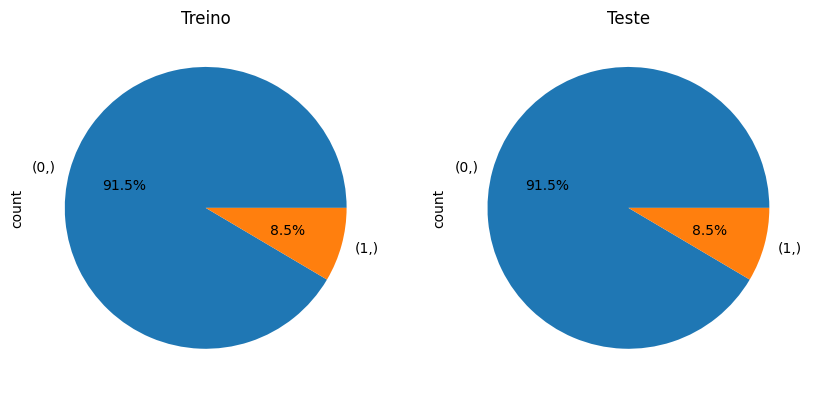

In [13]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
valores = pd.DataFrame(y_train).value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Treino')

plt.subplot(1, 2, 2)
valores = pd.DataFrame(y_test).value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Teste')

plt.show()


# Criando um modelo

In [14]:
resultado = []

def treinamento(nome, model_):
    x_train, x_test, y_train, y_test = preparar_dataset()

    model_.fit(x_train, y_train)
    y_pred = model_.predict(x_test)

    classification_report_ = classification_report(y_test, y_pred, output_dict=True)
    aux = classification_report_['0']
    aux['model'] = nome
    aux['label'] = '0'
    resultado.append(aux)

    aux = classification_report_['1']
    aux['model'] = nome
    aux['label'] = '1'
    resultado.append(aux)

modelos = [
    ('Dummy', DummyClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

for nome, modelo in modelos:
    treinamento(nome, modelo)

resultado = pd.DataFrame(resultado)
resultado = resultado[['model', 'label', 'precision', 'recall', 'f1-score']]

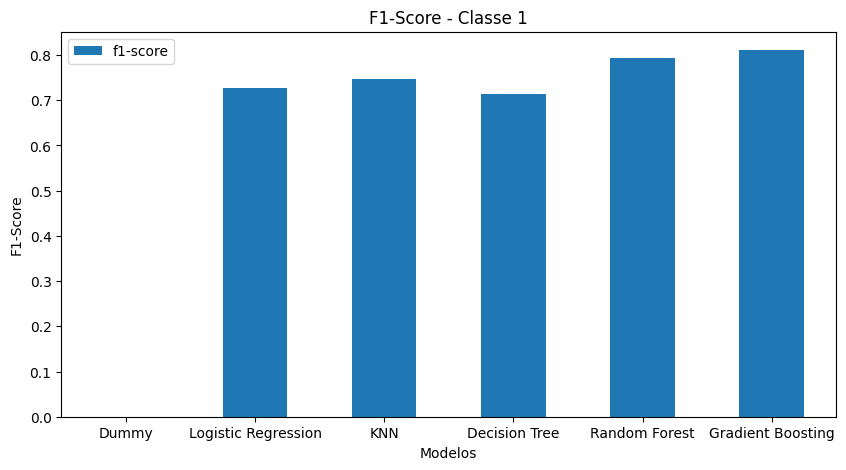

In [17]:
resultado[resultado['label'] == '1']['f1-score'].plot(kind='bar', figsize=(10, 5), legend=True)
plt.title('F1-Score - Classe 1')
plt.xticks([i for i in range(len(resultado[resultado['label'] == '1']))], resultado[resultado['label'] == '1']['model'], rotation=0)
plt.xlabel('Modelos')
plt.ylabel('F1-Score')
plt.show()

- Vamos escolher o Gradient Boosting como o modelo selecionado
---

In [19]:
x_train, x_test, y_train, y_test = preparar_dataset()

model = GradientBoostingClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18300
           1       0.99      0.69      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.98      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

